# Resnet V4.
resnet v3과 같은데 resnet34d를 사용

# Import

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import KFold

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

사용 디바이스: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [14]:
import random
import numpy as np
import torch

# ============================================================
# 재현성 보장 (Reproducibility)
# ============================================================

SEED = 42

def set_seed(seed=SEED):
    """모든 난수 생성기의 시드를 고정하여 재현성 보장"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # multi-GPU
    
    # CUDA 결정론적 동작 활성화
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # PyTorch 결정론적 알고리즘 사용 (PyTorch 1.8+)
    torch.use_deterministic_algorithms(True, warn_only=True)
    
    print(f"✅ Random Seed 고정 완료: {seed}")
    print(f"   - Python random: {seed}")
    print(f"   - NumPy: {seed}")
    print(f"   - PyTorch: {seed}")
    print(f"   - CUDA: {seed}")
    print(f"   - cuDNN Deterministic: True")
    print(f"   - cuDNN Benchmark: False")
    print(f"   - PyTorch Deterministic Algorithms: True")

# Seed 적용
set_seed(SEED)

✅ Random Seed 고정 완료: 42
   - Python random: 42
   - NumPy: 42
   - PyTorch: 42
   - CUDA: 42
   - cuDNN Deterministic: True
   - cuDNN Benchmark: False
   - PyTorch Deterministic Algorithms: True


# Data Load

In [ ]:
# 하이퍼파라미터
img_size = 256
batch_size = 64
num_classes = 10
num_epochs = 50
# learning_rate = 0.0003 -> train section
num_workers = 0
version = "4"

# 데이터 경로
base_dir = r'c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj'
driver_csv_path = os.path.join(base_dir, 'data', 'driver_imgs_list.csv')
train_dir = os.path.join(base_dir, 'data', 'imgs', 'train')
test_dir = os.path.join(base_dir, 'data', 'imgs', 'test')
best_model_path = f'models/inception_v{version}.pth'

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
print(f"이미지 크기: {img_size}x{img_size}")
print(f"배치 크기: {batch_size}")

Train directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\train
Test directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\test
이미지 크기: 256x256
배치 크기: 64


In [16]:
driver_df = pd.read_csv(driver_csv_path)

print(f"고유 운전자 수: {driver_df['subject'].nunique()}명")
print(f"운전자 목록: {sorted(driver_df['subject'].unique())}")

# driver_counts = driver_df['subject'].value_counts().sort_index()

# plt.figure(figsize=(12, 6))
# plt.bar(driver_counts.index.astype(str), driver_counts.values, color='C0', alpha=0.9)
# plt.xlabel('Driver')
# plt.ylabel('Image Count')
# plt.title('Images per Driver')
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()

고유 운전자 수: 26명
운전자 목록: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


# 5-Fold Cross Validation
fold별 운전자 목록을 미리 나누긴 하되 초기 실험 단계에서는 한 폴드(fold 2, 학습 데이터가 가장 많아서..)만 사용하고 이후 마무리 단계에서 전체 폴드 다 돌려서 일반화 성능 끌어올리는 방향으로 진행.

## split train data into 5 folds

In [17]:
all_drivers = sorted(driver_df['subject'].unique())

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_splits = []
for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(all_drivers)):
	train_drivers = [all_drivers[i] for i in train_indices]
	val_drivers = [all_drivers[i] for i in val_indices]

	fold_splits.append({
		'fold': fold_idx+1,
		'train_drivers': train_drivers,
		'val_drivers': val_drivers
	})

	print("Fold", fold_idx+1)
	print("train:", train_drivers, "val:", val_drivers)
	
	train_imgs = driver_df[driver_df['subject'].isin(train_drivers)]
	val_imgs = driver_df[driver_df['subject'].isin(val_drivers)]
	print(f"학습 이미지: {len(train_imgs)}개")
	print(f"검증 이미지: {len(val_imgs)}개")

Fold 1
train: ['p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p039', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p081'] val: ['p002', 'p026', 'p035', 'p041', 'p050', 'p075']
학습 이미지: 17446개
검증 이미지: 4978개
Fold 2
train: ['p002', 'p015', 'p016', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p075', 'p081'] val: ['p012', 'p014', 'p021', 'p045', 'p072']
학습 이미지: 18418개
검증 이미지: 4006개
Fold 3
train: ['p002', 'p012', 'p014', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p045', 'p047', 'p050', 'p051', 'p052', 'p056', 'p061', 'p066', 'p072', 'p075', 'p081'] val: ['p015', 'p016', 'p042', 'p049', 'p064']
학습 이미지: 18049개
검증 이미지: 4375개
Fold 4
train: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p056', 'p064', 'p072', 'p075'] val: ['p051', 'p052', 'p061', 'p066', 'p081

## define DraiverDataset

In [18]:
class DriverDataset(Dataset):
    """운전자 행동 데이터셋"""
    
    def __init__(self, data_dir, driver_df, driver_list, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.is_test = is_test
        self.images = []
        self.labels = []
        
        if is_test:
            test_images_dir = data_dir
            for img_name in os.listdir(test_images_dir):
                self.images.append(os.path.join(test_images_dir, img_name))
        else: #is_train
            driver_subset = driver_df[driver_df['subject'].isin(driver_list)]

            for _, row in driver_subset.iterrows():
                class_name = row['classname']
                img_name = row['img']
                img_path = os.path.join(data_dir, class_name, img_name)

                self.images.append(img_path)
                class_idx = int(class_name[1:])
                self.labels.append(class_idx)
        print(f"{'테스트' if is_test else '운전자' + str(len(driver_list))+'명'}, 데이터 {len(self.images)}개 이미지")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, os.path.basename(img_path)
        else:
            label = self.labels[idx]
            return image, label

## define online team transform

In [19]:
# team_transform_train = transforms.Compose([
# 	transforms.Resize((img_size, img_size)),
# 	transforms.RandomRotation(degrees=15),
# 	transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.15),

# 	transforms.ToTensor(),
# 	transforms.RandomErasing(p=0.5),
# 	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])

# team_transform_eval = transforms.Compose([
# 	transforms.Resize((img_size, img_size)),
# 	transforms.ToTensor(),
# 	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])

team_transform_train = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.RandomRotation(degrees=10),
	transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),

	transforms.ToTensor(),
	transforms.RandomErasing(p=0.25),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

team_transform_eval = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

## train

In [20]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    한 에폭(Epoch) 동안 모델을 학습시키고 손실과 정확도를 반환합니다.
    """
    model.train()  # 모델을 학습 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 훈련 데이터셋의 모든 배치를 반복합니다.
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 그래디언트 초기화
        optimizer.zero_grad()
        
        # 순전파 (Forward pass)
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
        
        # 역전파 및 최적화 (Backward pass and optimization)
        loss.backward()
        optimizer.step()
        
        # 통계 업데이트
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    return epoch_loss, epoch_acc.item()

In [21]:
def validate(model, val_loader, criterion, device):
    """
    검증 데이터셋을 이용해 모델의 성능(손실과 정확도)을 평가하고 반환합니다.
    """
    model.eval()  # 모델을 평가 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 그래디언트 계산을 비활성화합니다.
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
            
            # 통계 업데이트
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    # epoch_loss가 Log Loss에 해당하며, 이 값을 기준으로 최고 성능 모델을 저장합니다.
    return epoch_loss, epoch_acc.item()

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from torch.utils.data import DataLoader
import timm
import numpy as np
from sklearn.metrics import f1_score, log_loss
from tqdm import tqdm

# ===== 실험 스위치 / 하이퍼 =====
USE_GEM = True          # GeM pooling 사용
USE_ARCFACE = True     # ArcFace margin loss 사용 (True면 아래 ArcMarginProduct가 활성)
EMBED_DIM = 512         # ArcFace나 MLP head의 중간 임베딩 차원
DROPOUT = 0.4
DROP_PATH = 0.1         # timm drop-path (stochastic depth)
EARLY_STOP_PATIENCE = 10  # 15 -> 10으로 축소 (과적합 방지)

# ===== GeM Pooling =====
class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        x = nn.functional.avg_pool2d(x, (x.size(-2), x.size(-1)))
        return x.pow(1.0 / self.p)

# ===== ArcFace Margin Head =====
class ArcMarginProduct(nn.Module):
    """
    입력: (B, feat_dim) L2-normalized 임베딩, 라벨 (B,)
    출력: (B, num_classes) margin이 적용된 로짓
    """
    def __init__(self, feat_dim, num_classes, s=30.0, m=0.30, easy_margin=False):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, feat_dim))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin
        self.cos_m = np.cos(m)
        self.sin_m = np.sin(m)
        self.th = np.cos(np.pi - m)
        self.mm = np.sin(np.pi - m) * m

    def forward(self, embeddings, labels):
        # normalize
        embeddings = nn.functional.normalize(embeddings)
        W = nn.functional.normalize(self.weight)
        cosine = nn.functional.linear(embeddings, W)  # (B, C)
        sine = torch.sqrt(torch.clamp(1.0 - cosine**2, min=1e-9))
        phi = cosine * self.cos_m - sine * self.sin_m     # cos(theta + m)

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# ===== 백본 + 커스텀 헤드 래퍼 =====
class ResNetDWithHead(nn.Module):
    def __init__(self, num_classes, use_gem=True, embed_dim=512, dropout=0.4, use_arcface=False):
        super().__init__()
        # timm 백본: 분류기 제거(num_classes=0), 전역풀 제거(global_pool='')
        self.backbone = timm.create_model(
            'resnet34d',
            pretrained=True,
            num_classes=0,
            global_pool='',
            drop_path_rate=DROP_PATH,
        )
        self.use_gem = use_gem
        self.pool = GeM() if use_gem else nn.AdaptiveAvgPool2d((1, 1))

        in_ch = self.backbone.num_features
        self.use_arcface = use_arcface

        # 공통: 백본 출력 -> 임베딩
        self.embed = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
        )
        self.proj = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(in_ch, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        # 최종 분류기
        if use_arcface:
            self.classifier = ArcMarginProduct(embed_dim, num_classes, s=30.0, m=0.30)
        else:
            self.classifier = nn.Linear(embed_dim, num_classes)

    def forward_features_map(self, x):
        return self.backbone.forward_features(x)  # (B, C, H, W)

    def forward(self, x, labels=None):
        x = self.forward_features_map(x)
        x = self.embed(x)
        x = self.pool(x).flatten(1)
        x = self.proj(x)

        if self.use_arcface:
            # assert labels is not None, "ArcFace 사용 시 forward에 labels가 필요합니다."
            logits = self.classifier(x, labels)
        else:
            logits = self.classifier(x)
        return logits

def worker_init_fn(worker_id):
    """DataLoader worker의 재현성 보장"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ======================================================================
def train_fold(fold_idx, train_drivers, val_drivers):
    """
    EXP-1+: ResNet-26-D + (GeM, MLP head) [옵션 ArcFace]
      - Freeze: stem~layer1 동결 (layer2~4 + head만 학습)
      - Optimizer: AdamW
      - Scheduler: Warmup(5ep) -> CosineAnnealing
      - Loss: CE(label_smoothing=0.1) 또는 ArcFace 사용 시 CE(without smoothing)
      - Early Stop / Best Save: macro-F1
      - 추가: drop-path, anti-alias
    """
    print(f"==== Fold {fold_idx}/{n_folds} ====")

    # ===== 데이터셋 & 로더 =====
    g = torch.Generator()
    g.manual_seed(SEED)

    train_dataset = DriverDataset(
        train_dir, driver_df, train_drivers,
        transform=team_transform_train, is_test=False
    )
    val_dataset = DriverDataset(
        train_dir, driver_df, val_drivers,
        transform=team_transform_eval, is_test=False
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True,
                              worker_init_fn=worker_init_fn, generator=g)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True,
                            worker_init_fn=worker_init_fn, generator=g)

    print(f"학습 배치 수: {len(train_loader)}")
    print(f"검증 배치 수: {len(val_loader)}")

    # ===== 모델 =====
    model = ResNetDWithHead(
        num_classes=num_classes,
        use_gem=USE_GEM,
        embed_dim=EMBED_DIM,
        dropout=DROPOUT,
        use_arcface=USE_ARCFACE
    ).to(device)

    # ---- layer1까지 동결 (stem~layer1 freeze) ----
    for name, p in model.backbone.named_parameters():
        if name.startswith('layer2') or name.startswith('layer3') or name.startswith('layer4'):
            p.requires_grad = True
        else:
            p.requires_grad = False
    # head는 학습
    for p in model.embed.parameters(): p.requires_grad = True
    for p in model.proj.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print("\n" + "="*70)
    print("📊 모델 파라미터 통계 (EXP-1+: ResNet-34-D + GeM/MLP)")
    print("="*70)
    print(f"  전체 파라미터:      {total_params:>15,}")
    print(f"  학습 가능 파라미터:  {trainable_params:>15,} ({100*trainable_params/total_params:>6.2f}%)")
    print("="*70 + "\n")

    # ===== 손실/옵티마/스케줄러 =====
    if USE_ARCFACE:
        # ArcFace는 margin-logits에 일반 CrossEntropy 사용(스무딩 비권장)
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=3e-4,
        weight_decay=5e-2
    )
    warmup_epochs = 5
    cosine_epochs = max(1, num_epochs - warmup_epochs)
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs),
            CosineAnnealingLR(optimizer, T_max=cosine_epochs)
        ],
        milestones=[warmup_epochs]
    )

    # ===== 기록 =====
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
               'val_macro_f1': [], 'val_logloss': [], 'learning_rates': []}

    # ===== Early Stopping =====
    early_stop_patience = EARLY_STOP_PATIENCE
    patience_counter = 0
    best_metric = -float('inf')
    best_model_path = f'models/resnet_v{version}.pth'

    print(f"\n⏱️ Early Stopping Patience (macro-F1 기준): {early_stop_patience} ep\n")
    print("="*70); print("🚀 학습 시작 (EXP-1+)"); print("="*70)

    def eval_on_loader(model, loader, criterion):
        model.eval()
        total, correct, running_loss = 0, 0, 0.0
        all_probs, all_labels = [], []
        with torch.no_grad():
            pbar = tqdm(loader, desc='Validating', leave=False)
            for images, labels in pbar:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                if USE_ARCFACE:
                    # forward에 labels 전달하여 margin logits 생성
                    logits = model(images, labels=labels)
                else:
                    logits = model(images)

                loss = criterion(logits, labels)
                running_loss += loss.item() * labels.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                probs = logits.softmax(dim=1).detach().cpu().numpy()
                all_probs.append(probs)
                all_labels.append(labels.detach().cpu().numpy())
                pbar.set_postfix({'loss': f'{loss.item():.4f}',
                                  'acc': f'{100.0*correct/max(1,total):.2f}%'})

        avg_loss = running_loss / max(1, total)
        acc = 100.0 * correct / max(1, total)
        all_probs = np.concatenate(all_probs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        macro_f1 = f1_score(all_labels, np.argmax(all_probs, axis=1), average='macro')
        mlogloss = log_loss(all_labels, all_probs, labels=list(range(num_classes)))
        return avg_loss, acc, macro_f1, mlogloss

    # ===== 에폭 루프 =====
    for epoch in range(num_epochs):
        print(f'\n{"="*70}')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'{"="*70}')
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)

        # ---- Train ----
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc='Training', leave=False)
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            if USE_ARCFACE:
                logits = model(images, labels=labels)
            else:
                logits = model(images)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            pbar.set_postfix({'loss': f'{loss.item():.4f}',
                              'acc': f'{100.0*train_correct/max(1,train_total):.2f}%',
                              'lr': f'{current_lr:.6f}'})

        epoch_train_loss = train_loss / max(1, train_total)
        epoch_train_acc = 100.0 * train_correct / max(1, train_total)

        # ---- Validate ----
        val_loss, val_acc, val_macro_f1, val_logloss = eval_on_loader(model, val_loader, criterion)
        scheduler.step()

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_macro_f1'].append(val_macro_f1)
        history['val_logloss'].append(val_logloss)

        print(f'\n📊 Epoch {epoch+1} 결과:')
        print(f'  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
        print(f'  Val   Loss: {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        print(f'  Val Macro-F1: {val_macro_f1:.4f} | Val LogLoss: {val_logloss:.4f}')
        print(f'  LR: {current_lr:.6f}')

        # ---- Best / Early Stop ----
        if val_macro_f1 > best_metric:
            best_metric = val_macro_f1
            patience_counter = 0
            torch.save({
                'fold': fold_idx,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_macro_f1': val_macro_f1,
                'val_logloss': val_logloss,
                'model_name': 'resnet26d',
                'freeze_mode': 'freeze_to_layer1',
                'use_gem': USE_GEM,
                'use_arcface': USE_ARCFACE,
                'drop_path_rate': DROP_PATH,
                'aa_mode': AA_MODE,
                'trainable_params': trainable_params,
                'total_params': total_params,
                'seed': SEED
            }, best_model_path)
            print(f'  ✅ 최고 성능(매크로F1) 모델 저장! (Macro-F1: {val_macro_f1:.4f})')
        else:
            patience_counter += 1
            print(f'  ⏳ Early Stopping 카운터: {patience_counter}/{EARLY_STOP_PATIENCE}')
            if patience_counter >= EARLY_STOP_PATIENCE:
                print(f'\n{"="*70}')
                print(f'🛑 Early Stopping 발동! (Epoch {epoch+1}) — macro-F1 개선 없음')
                print(f'   최고 Macro-F1: {best_metric:.4f}')
                print(f'   모델 저장 경로: {best_model_path}')
                print(f'{"="*70}')
                break

    final_epoch = epoch + 1
    print("\n" + "="*70)
    print(f"✅ Fold {fold_idx} 학습 완료! (EXP-1+)")
    print("="*70)
    print(f"  총 학습 에폭: {final_epoch}/{num_epochs}")
    print(f"  최고 Macro-F1: {max(history['val_macro_f1']):.4f}")
    print(f"  최저 Val Loss: {min(history['val_loss']):.4f}")
    print(f"  최저 LogLoss:  {min(history['val_logloss']):.4f}")
    print(f"  최고 Val Acc:  {max(history['val_acc']):.2f}%")
    print(f"  모델 저장: {best_model_path}")
    print(f"  학습 파라미터: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")
    print("="*70)

    return {
        'fold': fold_idx,
        'history': history,
        'best_macro_f1': max(history['val_macro_f1']),
        'best_val_loss': min(history['val_loss']),
        'best_val_logloss': min(history['val_logloss']),
        'best_val_acc': max(history['val_acc']),
        'model_path': best_model_path,
        'stopped_epoch': final_epoch,
        'model_name': 'resnet26d_gem_mlp' + ('_arcface' if USE_ARCFACE else ''),
        'freeze_mode': 'freeze_to_layer1',
        'trainable_params': trainable_params,
        'total_params': total_params,
        'seed':SEED
    }


In [25]:
# ========== Fold 2 학습 (Inception-C부터 Fine-tuning) ==========

all_fold_results = []

fold_info = fold_splits[1]  # Fold 2
fold_idx = fold_info['fold']
train_drivers = fold_info['train_drivers']
val_drivers = fold_info['val_drivers']


print(f"==== Resnet v{version} ====")


fold_result = train_fold(
    fold_idx, 
    train_drivers, 
    val_drivers,
)

all_fold_results.append(fold_result)

# 메모리 정리
torch.cuda.empty_cache()

# 결과 출력
print(f"\n{'='*70}")
print("📊 최종 결과")
print(f"{'='*70}")
print(f"  Fold: {fold_result['fold']}")
print(f"  최저 Val Loss: {fold_result['best_val_loss']:.4f}")
print(f"  해당 Val Acc: {fold_result['best_val_acc']:.2f}%")
# print(f"  최고 Val Acc: {fold_result['max_val_acc']:.2f}%")
print(f"  학습 완료 에폭: {fold_result['stopped_epoch']}")
print(f"  Freeze 모드: {fold_result['freeze_mode']}")
print(f"  학습 파라미터: {fold_result['trainable_params']:,} / {fold_result['total_params']:,}")
print(f"{'='*70}")

==== Resnet v3 ====
==== Fold 2/5 ====
운전자21명, 데이터 18418개 이미지
운전자5명, 데이터 4006개 이미지
학습 배치 수: 288
검증 배치 수: 63

📊 모델 파라미터 통계 (EXP-1+: ResNet-34-D + GeM/MLP)
  전체 파라미터:           21,835,873
  학습 가능 파라미터:       21,585,153 ( 98.85%)


⏱️ Early Stopping Patience (macro-F1 기준): 10 ep

🚀 학습 시작 (EXP-1+)

Epoch 1/50



📊 Epoch 1 결과:
  Train Loss: 11.6674 | Train Acc: 0.00%
  Val   Loss: 11.5579 | Val Acc:   0.00%
  Val Macro-F1: 0.0000 | Val LogLoss: 11.5578
  LR: 0.000003
  ✅ 최고 성능(매크로F1) 모델 저장! (Macro-F1: 0.0000)

Epoch 2/50



📊 Epoch 2 결과:
  Train Loss: 7.0878 | Train Acc: 21.72%
  Val   Loss: 2.6953 | Val Acc:   71.29%
  Val Macro-F1: 0.6927 | Val LogLoss: 2.4849
  LR: 0.000062
  ✅ 최고 성능(매크로F1) 모델 저장! (Macro-F1: 0.6927)

Epoch 3/50



📊 Epoch 3 결과:
  Train Loss: 1.3776 | Train Acc: 83.21%
  Val   Loss: 2.3463 | Val Acc:   83.85%
  Val Macro-F1: 0.8258 | Val LogLoss: 1.8602
  LR: 0.000122
  ✅ 최고 성능(매크로F1) 모델 저장! (Macro-F1: 0.8258)

Epoch 4/50



📊 Epoch 4 결과:
  Train Loss: 0.8324 | Train Acc: 90.68%
  Val   Loss: 2.9621 | Val Acc:   82.08%
  Val Macro-F1: 0.8096 | Val LogLoss: 2.0993
  LR: 0.000181
  ⏳ Early Stopping 카운터: 1/10

Epoch 5/50



📊 Epoch 5 결과:
  Train Loss: 0.6296 | Train Acc: 92.95%
  Val   Loss: 3.1265 | Val Acc:   81.45%
  Val Macro-F1: 0.8133 | Val LogLoss: 2.2554
  LR: 0.000241
  ⏳ Early Stopping 카운터: 2/10

Epoch 6/50



📊 Epoch 6 결과:
  Train Loss: 0.5571 | Train Acc: 94.26%
  Val   Loss: 3.6151 | Val Acc:   81.85%
  Val Macro-F1: 0.7993 | Val LogLoss: 2.3716
  LR: 0.000300
  ⏳ Early Stopping 카운터: 3/10

Epoch 7/50



📊 Epoch 7 결과:
  Train Loss: 0.4213 | Train Acc: 95.59%
  Val   Loss: 2.4529 | Val Acc:   87.04%
  Val Macro-F1: 0.8554 | Val LogLoss: 1.6335
  LR: 0.000300
  ✅ 최고 성능(매크로F1) 모델 저장! (Macro-F1: 0.8554)

Epoch 8/50



📊 Epoch 8 결과:
  Train Loss: 0.3672 | Train Acc: 95.92%
  Val   Loss: 2.6141 | Val Acc:   84.80%
  Val Macro-F1: 0.8320 | Val LogLoss: 1.8338
  LR: 0.000299
  ⏳ Early Stopping 카운터: 1/10

Epoch 9/50



📊 Epoch 9 결과:
  Train Loss: 0.3310 | Train Acc: 96.45%
  Val   Loss: 3.1889 | Val Acc:   83.20%
  Val Macro-F1: 0.8099 | Val LogLoss: 2.1120
  LR: 0.000297
  ⏳ Early Stopping 카운터: 2/10

Epoch 10/50



📊 Epoch 10 결과:
  Train Loss: 0.2802 | Train Acc: 96.88%
  Val   Loss: 3.1823 | Val Acc:   84.42%
  Val Macro-F1: 0.8236 | Val LogLoss: 2.0624
  LR: 0.000294
  ⏳ Early Stopping 카운터: 3/10

Epoch 11/50



📊 Epoch 11 결과:
  Train Loss: 0.2734 | Train Acc: 96.93%
  Val   Loss: 2.7933 | Val Acc:   83.05%
  Val Macro-F1: 0.8169 | Val LogLoss: 1.9675
  LR: 0.000291
  ⏳ Early Stopping 카운터: 4/10

Epoch 12/50



📊 Epoch 12 결과:
  Train Loss: 0.2465 | Train Acc: 97.28%
  Val   Loss: 2.1543 | Val Acc:   86.45%
  Val Macro-F1: 0.8537 | Val LogLoss: 1.5448
  LR: 0.000287
  ⏳ Early Stopping 카운터: 5/10

Epoch 13/50



📊 Epoch 13 결과:
  Train Loss: 0.2316 | Train Acc: 97.38%
  Val   Loss: 3.0087 | Val Acc:   84.07%
  Val Macro-F1: 0.8255 | Val LogLoss: 2.0208
  LR: 0.000282
  ⏳ Early Stopping 카운터: 6/10

Epoch 14/50



📊 Epoch 14 결과:
  Train Loss: 0.2266 | Train Acc: 97.60%
  Val   Loss: 2.5839 | Val Acc:   83.92%
  Val Macro-F1: 0.8222 | Val LogLoss: 1.9107
  LR: 0.000277
  ⏳ Early Stopping 카운터: 7/10

Epoch 15/50



📊 Epoch 15 결과:
  Train Loss: 0.1905 | Train Acc: 97.80%
  Val   Loss: 3.1519 | Val Acc:   83.10%
  Val Macro-F1: 0.8115 | Val LogLoss: 2.1813
  LR: 0.000271
  ⏳ Early Stopping 카운터: 8/10

Epoch 16/50



📊 Epoch 16 결과:
  Train Loss: 0.1958 | Train Acc: 97.77%
  Val   Loss: 2.8691 | Val Acc:   84.32%
  Val Macro-F1: 0.8314 | Val LogLoss: 1.9719
  LR: 0.000265
  ⏳ Early Stopping 카운터: 9/10

Epoch 17/50



📊 Epoch 17 결과:
  Train Loss: 0.1706 | Train Acc: 97.94%
  Val   Loss: 2.9530 | Val Acc:   83.47%
  Val Macro-F1: 0.8272 | Val LogLoss: 2.0133
  LR: 0.000258
  ⏳ Early Stopping 카운터: 10/10

🛑 Early Stopping 발동! (Epoch 17) — macro-F1 개선 없음
   최고 Macro-F1: 0.8554
   모델 저장 경로: models/resnet_v3.pth

✅ Fold 2 학습 완료! (EXP-1+)
  총 학습 에폭: 17/50
  최고 Macro-F1: 0.8554
  최저 Val Loss: 2.1543
  최저 LogLoss:  1.5448
  최고 Val Acc:  87.04%
  모델 저장: models/resnet_v3.pth
  학습 파라미터: 21,585,153 / 21,835,873 (98.85%)

📊 최종 결과
  Fold: 2
  최저 Val Loss: 2.1543
  해당 Val Acc: 87.04%
  학습 완료 에폭: 17
  Freeze 모드: freeze_to_layer1
  학습 파라미터: 21,585,153 / 21,835,873


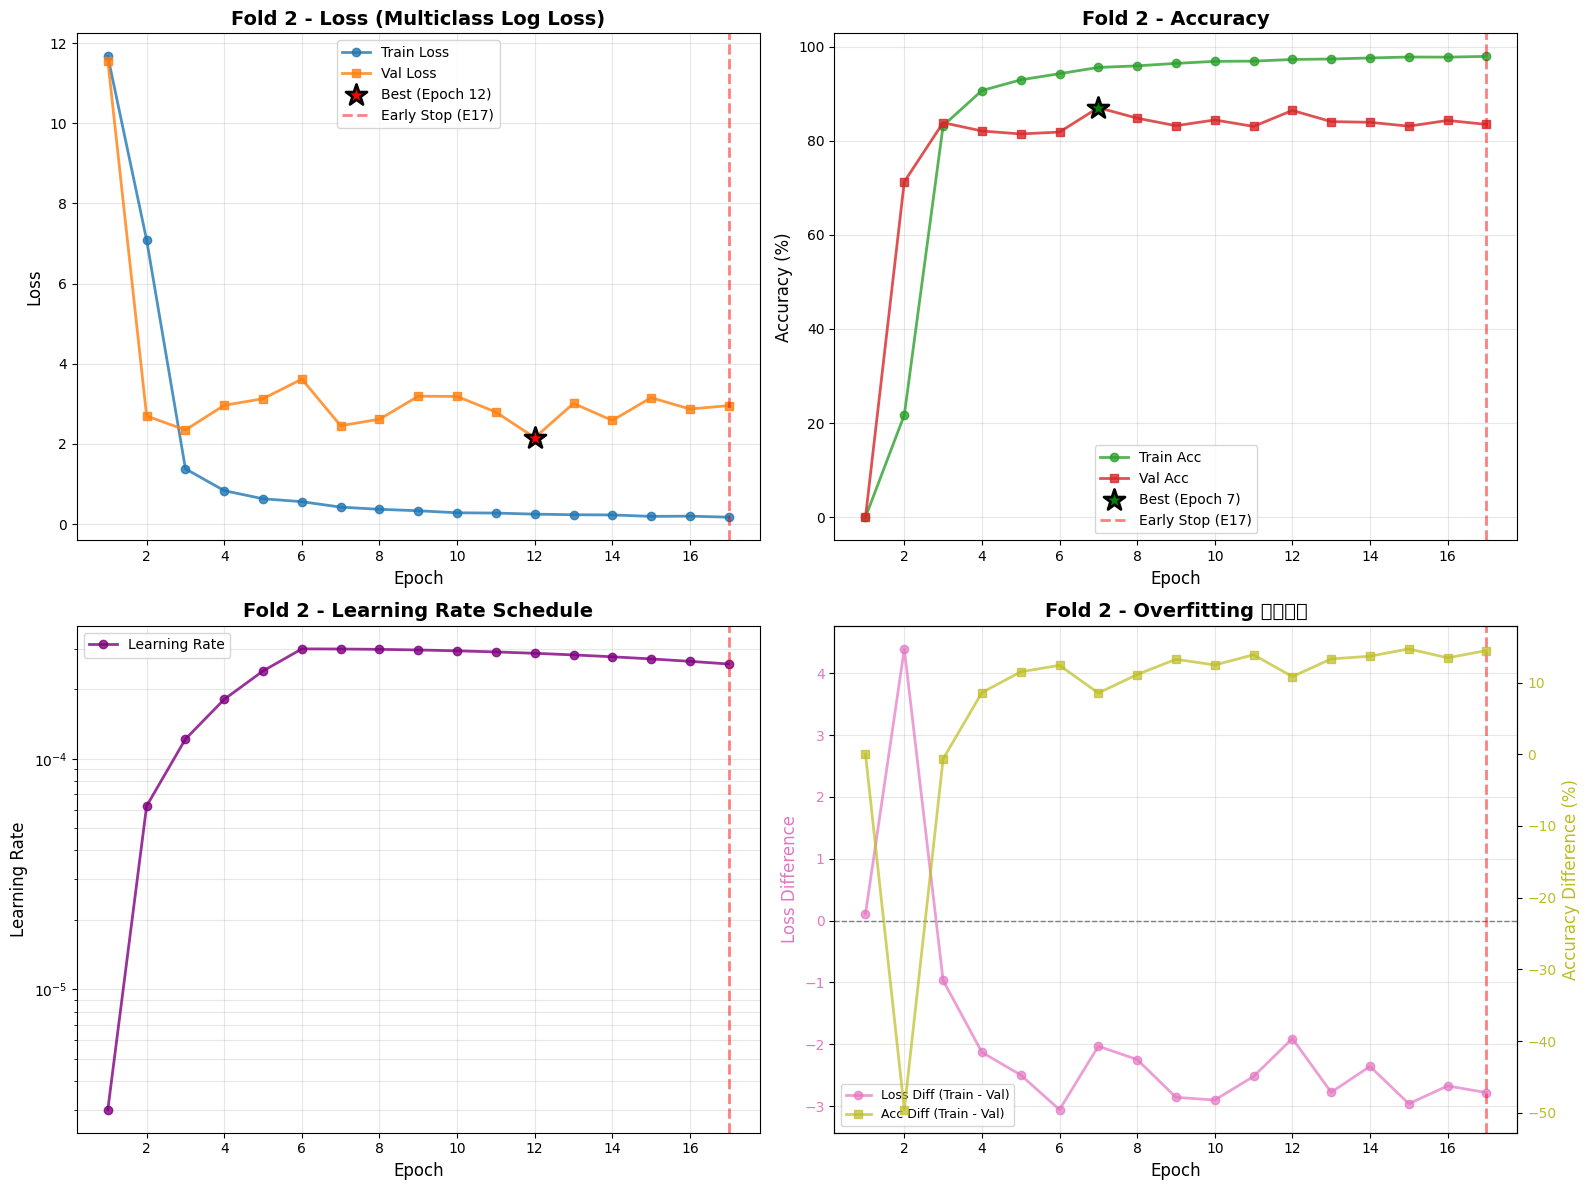


📈 학습 통계 상세
초기 Train Loss: 11.6674
최종 Train Loss: 0.1706
최저 Train Loss: 0.1706 (Epoch 17)

초기 Val Loss: 11.5579
최종 Val Loss: 2.9530
최저 Val Loss: 2.1543 (Epoch 12)

초기 Train Acc: 0.00%
최종 Train Acc: 97.94%
최고 Train Acc: 97.94% (Epoch 17)

초기 Val Acc: 0.00%
최종 Val Acc: 83.47%
최고 Val Acc: 87.04% (Epoch 7)

초기 LR: 0.000003
최종 LR: 0.000258
LR 변경 횟수: 16회

🔍 Overfitting 분석
최종 Loss 차이 (Train - Val): -2.7824
최종 Acc 차이 (Train - Val): +14.46%
⚠️ 경고: 심각한 Overfitting 감지! (Acc 차이 > 10%)


In [27]:
# ========== 학습 곡선 시각화 (4개 그래프) ==========

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for result in all_fold_results:
    fold_idx = result['fold']
    history = result['history']
    stopped_epoch = result['stopped_epoch']
    best_val_loss = result['best_val_loss']
    
    # 1. Loss 그래프
    ax1 = axes[0, 0]
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], label='Train Loss', 
             marker='o', linewidth=2, alpha=0.8, color='#1f77b4')
    ax1.plot(epochs, history['val_loss'], label='Val Loss', 
             marker='s', linewidth=2, alpha=0.8, color='#ff7f0e')
    
    # 최저 Val Loss 지점 표시
    best_epoch = np.argmin(history['val_loss']) + 1
    ax1.scatter(best_epoch, best_val_loss, color='red', s=250, zorder=5, 
                marker='*', edgecolors='black', linewidths=2,
                label=f'Best (Epoch {best_epoch})')
    
    # Early Stopping 지점 표시
    if stopped_epoch < num_epochs:
        ax1.axvline(stopped_epoch, color='red', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f'Early Stop (E{stopped_epoch})')
    
    ax1.set_title(f'Fold {fold_idx} - Loss (Multiclass Log Loss)', 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. Accuracy 그래프
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['train_acc'], label='Train Acc', 
             marker='o', linewidth=2, alpha=0.8, color='#2ca02c')
    ax2.plot(epochs, history['val_acc'], label='Val Acc', 
             marker='s', linewidth=2, alpha=0.8, color='#d62728')
    
    # 최고 Val Acc 지점 표시
    best_acc_epoch = np.argmax(history['val_acc']) + 1
    best_val_acc = max(history['val_acc'])
    ax2.scatter(best_acc_epoch, best_val_acc, color='green', s=250, zorder=5,
                marker='*', edgecolors='black', linewidths=2,
                label=f'Best (Epoch {best_acc_epoch})')
    
    if stopped_epoch < num_epochs:
        ax2.axvline(stopped_epoch, color='red', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f'Early Stop (E{stopped_epoch})')
    
    ax2.set_title(f'Fold {fold_idx} - Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 3. Learning Rate 그래프
    ax3 = axes[1, 0]
    ax3.plot(epochs, history['learning_rates'], marker='o', linewidth=2, 
             color='purple', alpha=0.8, label='Learning Rate')
    ax3.set_title(f'Fold {fold_idx} - Learning Rate Schedule', 
                 fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Learning Rate', fontsize=12)
    ax3.set_yscale('log')
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3, which='both')
    
    if stopped_epoch < num_epochs:
        ax3.axvline(stopped_epoch, color='red', linestyle='--', 
                   linewidth=2, alpha=0.5)
    
    # 4. Train vs Val 비교 (Loss & Acc)
    ax4 = axes[1, 1]
    
    # Loss 차이
    loss_diff = np.array(history['train_loss']) - np.array(history['val_loss'])
    ax4_twin = ax4.twinx()
    
    ax4.plot(epochs, loss_diff, marker='o', linewidth=2, 
            color='#e377c2', alpha=0.7, label='Loss Diff (Train - Val)')
    ax4.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Loss Difference', fontsize=12, color='#e377c2')
    ax4.tick_params(axis='y', labelcolor='#e377c2')
    
    # Accuracy 차이
    acc_diff = np.array(history['train_acc']) - np.array(history['val_acc'])
    ax4_twin.plot(epochs, acc_diff, marker='s', linewidth=2,
                 color='#bcbd22', alpha=0.7, label='Acc Diff (Train - Val)')
    ax4_twin.set_ylabel('Accuracy Difference (%)', fontsize=12, color='#bcbd22')
    ax4_twin.tick_params(axis='y', labelcolor='#bcbd22')
    
    ax4.set_title(f'Fold {fold_idx} - Overfitting 모니터링', 
                 fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Legend 통합
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=9)
    
    if stopped_epoch < num_epochs:
        ax4.axvline(stopped_epoch, color='red', linestyle='--', 
                   linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig(f'./plots/resnet_v{version}_losscurve_detailed.png', 
           dpi=300, bbox_inches='tight')
plt.show()

# ========== 통계 출력 ==========
print("\n" + "="*70)
print("📈 학습 통계 상세")
print("="*70)
print(f"초기 Train Loss: {history['train_loss'][0]:.4f}")
print(f"최종 Train Loss: {history['train_loss'][-1]:.4f}")
print(f"최저 Train Loss: {min(history['train_loss']):.4f} (Epoch {np.argmin(history['train_loss'])+1})")
print(f"\n초기 Val Loss: {history['val_loss'][0]:.4f}")
print(f"최종 Val Loss: {history['val_loss'][-1]:.4f}")
print(f"최저 Val Loss: {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss'])+1})")
print(f"\n초기 Train Acc: {history['train_acc'][0]:.2f}%")
print(f"최종 Train Acc: {history['train_acc'][-1]:.2f}%")
print(f"최고 Train Acc: {max(history['train_acc']):.2f}% (Epoch {np.argmax(history['train_acc'])+1})")
print(f"\n초기 Val Acc: {history['val_acc'][0]:.2f}%")
print(f"최종 Val Acc: {history['val_acc'][-1]:.2f}%")
print(f"최고 Val Acc: {max(history['val_acc']):.2f}% (Epoch {np.argmax(history['val_acc'])+1})")
print(f"\n초기 LR: {history['learning_rates'][0]:.6f}")
print(f"최종 LR: {history['learning_rates'][-1]:.6f}")
print(f"LR 변경 횟수: {len(set(history['learning_rates'])) - 1}회")
print("="*70)

# ========== Overfitting 분석 ==========
final_loss_gap = history['train_loss'][-1] - history['val_loss'][-1]
final_acc_gap = history['train_acc'][-1] - history['val_acc'][-1]

print("\n" + "="*70)
print("🔍 Overfitting 분석")
print("="*70)
print(f"최종 Loss 차이 (Train - Val): {final_loss_gap:+.4f}")
print(f"최종 Acc 차이 (Train - Val): {final_acc_gap:+.2f}%")

if final_acc_gap > 10:
    print("⚠️ 경고: 심각한 Overfitting 감지! (Acc 차이 > 10%)")
elif final_acc_gap > 5:
    print("⚠️ 주의: 약간의 Overfitting 감지 (Acc 차이 > 5%)")
else:
    print("✅ 양호: Overfitting이 잘 제어되고 있습니다.")

print("="*70)

# Submission

In [29]:
# ========== Submission 파일 생성 (학습된 모델 사용) ==========

print("\n" + "=" * 70)
print("🔮 테스트 데이터 예측 시작")
print("=" * 70)

# 1. 테스트 데이터셋 생성
test_dataset = DriverDataset(
    test_dir, driver_df, [], 
    transform=team_transform_eval, is_test=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"테스트 샘플: {len(test_dataset)}개")

# 2. 모델 생성 (학습 시와 동일한 구조로)
model = ResNetDWithHead(
    num_classes=num_classes,
    use_gem=USE_GEM,
    embed_dim=EMBED_DIM,
    dropout=DROPOUT,
    use_arcface=USE_ARCFACE
).to(device)

# 3. 저장된 가중치 로드
best_model_path = f"./models/resnet_v3.pth"
print(f"\n📁 모델 로드 중: {best_model_path}...")

try:
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 로드된 모델 정보 출력
    print(f"✅ 모델 로드 완료!")
    print(f"   - Fold: {checkpoint.get('fold', 'N/A')}")
    print(f"   - Epoch: {checkpoint.get('epoch', 'N/A')+1}")
    print(f"   - Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
    print(f"   - Val Acc: {checkpoint.get('val_acc', 'N/A'):.2f}%")
    print(f"   - Val Macro-F1: {checkpoint.get('val_macro_f1', 'N/A'):.4f}")
    
except Exception as e:
    print(f"🚨 모델 로드 실패: {e}")
    raise

model.eval()

# 4. 예측 실행
predictions = []
img_names = []

print("\n🔮 예측 진행 중...")
with torch.no_grad():
    for images, filenames in tqdm(test_loader, desc='예측'):
        images = images.to(device, non_blocking=True)
        
        # ArcFace 사용 시 labels 없이 forward (추론 시에는 labels 불필요)
        if USE_ARCFACE:
            # ArcFace는 학습 시에만 labels 필요, 추론 시에는 classifier를 직접 사용
            x = model.forward_features_map(images)
            x = model.embed(x)
            x = model.pool(x).flatten(1)
            x = model.proj(x) if not isinstance(model.proj[0], nn.Flatten) else x
            # ArcFace classifier의 weight를 사용한 코사인 유사도 계산
            embeddings = nn.functional.normalize(x)
            W = nn.functional.normalize(model.classifier.weight)
            outputs = nn.functional.linear(embeddings, W) * model.classifier.s
        else:
            outputs = model(images)
        
        # 5. 확률 (Softmax) 계산
        probs = torch.softmax(outputs, dim=1)
        predictions.append(probs.cpu().numpy())
        img_names.extend(filenames)

final_predictions = np.vstack(predictions)
print(f"\n✅ 예측 완료: {final_predictions.shape}")

# 6. Submission 파일 생성
class_cols = [f'c{i}' for i in range(num_classes)]

submission_data = {'img': img_names}
for i, col in enumerate(class_cols):
    submission_data[col] = final_predictions[:, i]

submission = pd.DataFrame(submission_data)

# 7. 파일 저장
os.makedirs('./submissions', exist_ok=True)
submission_file = f'resnet_v{version}_submission.csv'
submission.to_csv("./submissions/" + submission_file, index=False)

print("\n" + "=" * 70)
print(f"✅ Submission 파일 생성 완료!")
print("=" * 70)
print(f"📁 저장 경로: ./submissions/{submission_file}")
print(f"📊 총 예측 이미지: {len(submission)}개")
print(f"📋 클래스별 평균 확률:")
for col in class_cols:
    print(f"   {col}: {submission[col].mean():.4f}")
print("=" * 70)

print("\n📋 Submission 샘플 (처음 5개):")
print(submission.head())

print("\n📋 Submission 샘플 (마지막 5개):")
print(submission.tail())

# 8. 확률 분포 검증 (합이 1인지 확인)
prob_sums = submission[class_cols].sum(axis=1)
print(f"\n✅ 확률 합 검증: min={prob_sums.min():.6f}, max={prob_sums.max():.6f}, mean={prob_sums.mean():.6f}")
if not np.allclose(prob_sums, 1.0, atol=1e-5):
    print("⚠️ 경고: 일부 샘플의 확률 합이 1이 아닙니다!")
else:
    print("✅ 모든 샘플의 확률 합이 1입니다.")


🔮 테스트 데이터 예측 시작
테스트, 데이터 79726개 이미지
테스트 샘플: 79726개

📁 모델 로드 중: ./models/resnet_v3.pth...
✅ 모델 로드 완료!
   - Fold: 2
   - Epoch: 7
   - Val Loss: 2.4529
   - Val Acc: 87.04%
   - Val Macro-F1: 0.8554

🔮 예측 진행 중...


예측: 100%|██████████| 1246/1246 [12:24<00:00,  1.67it/s]



✅ 예측 완료: (79726, 10)

✅ Submission 파일 생성 완료!
📁 저장 경로: ./submissions/resnet_v4_submission.csv
📊 총 예측 이미지: 79726개
📋 클래스별 평균 확률:
   c0: 0.0666
   c1: 0.0424
   c2: 0.0719
   c3: 0.0991
   c4: 0.1884
   c5: 0.2281
   c6: 0.0793
   c7: 0.0706
   c8: 0.0844
   c9: 0.0691

📋 Submission 샘플 (처음 5개):
              img        c0        c1        c2        c3        c4        c5  \
0       img_1.jpg  0.040590  0.050245  0.061334  0.050094  0.206836  0.412792   
1      img_10.jpg  0.027172  0.085807  0.057638  0.075282  0.335085  0.275160   
2     img_100.jpg  0.054019  0.041634  0.060255  0.044494  0.433045  0.167965   
3    img_1000.jpg  0.095822  0.067341  0.114403  0.210524  0.101923  0.120940   
4  img_100000.jpg  0.051764  0.051531  0.023808  0.149239  0.119814  0.230312   

         c6        c7        c8        c9  
0  0.068640  0.031892  0.050864  0.026713  
1  0.060445  0.019175  0.032406  0.031831  
2  0.056909  0.042410  0.080834  0.018437  
3  0.088886  0.070817  0.049951  0.079393  


# Analysis

운전자5명, 데이터 4006개 이미지


예측 중: 100%|██████████| 63/63 [01:19<00:00,  1.26s/it]


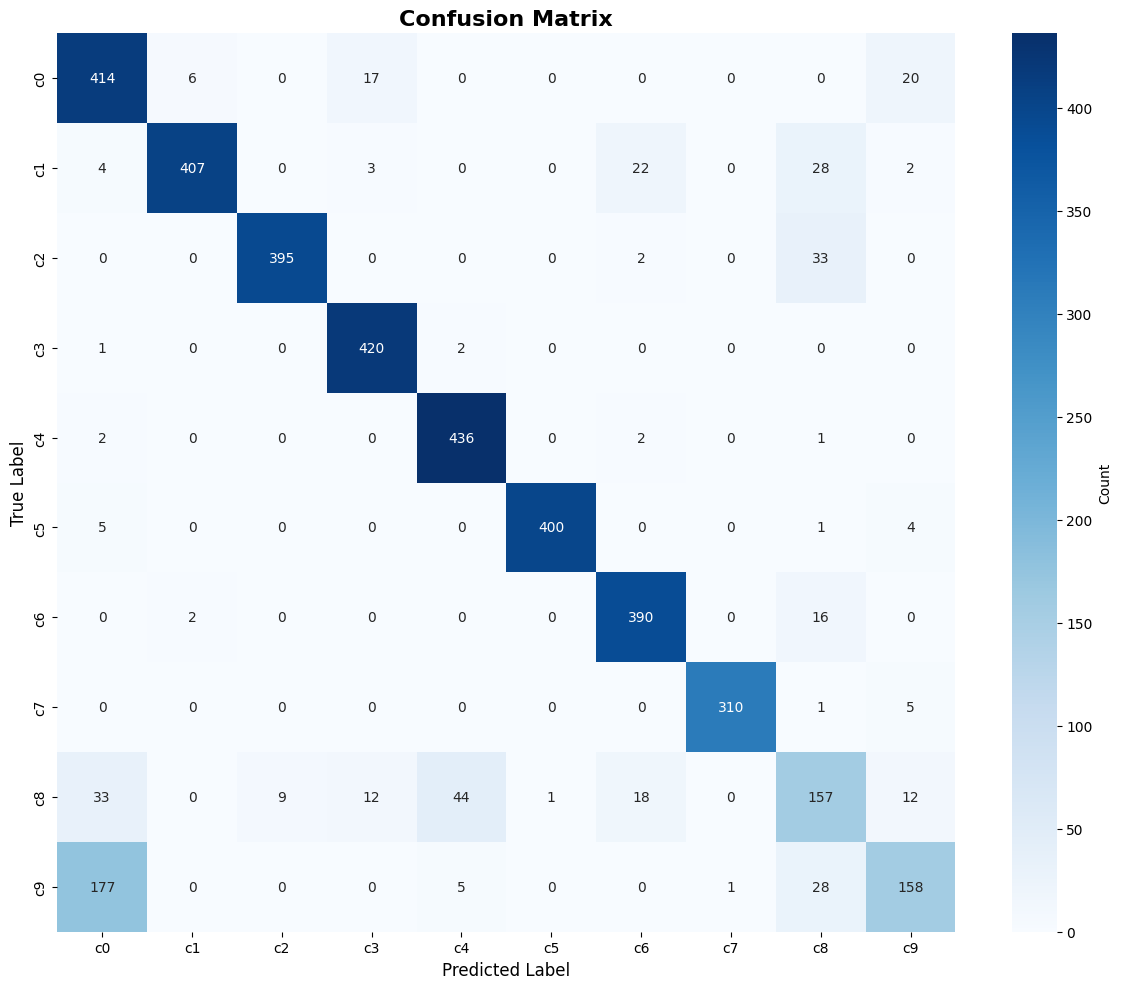

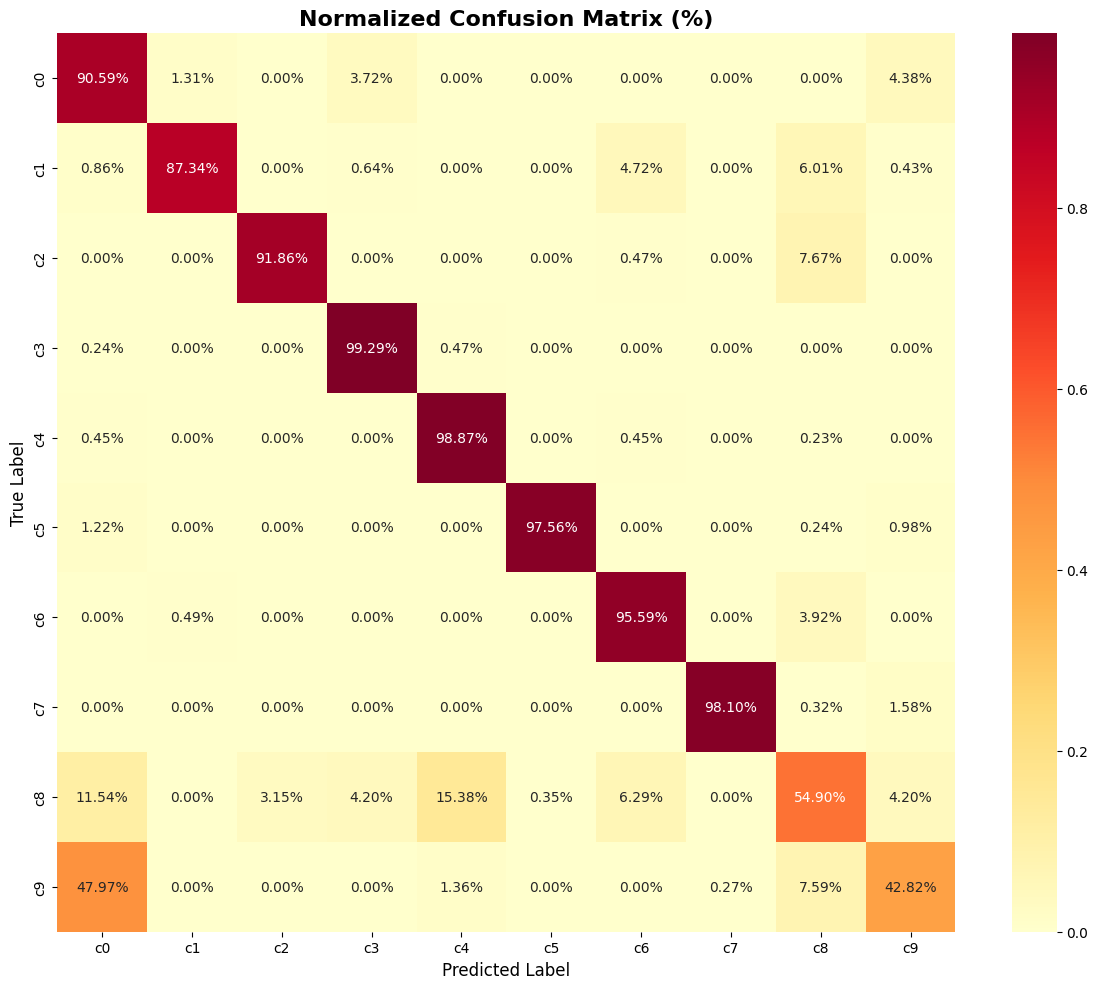


📊 Classification Report
              precision    recall  f1-score   support

          c0     0.6509    0.9059    0.7575       457
          c1     0.9807    0.8734    0.9240       466
          c2     0.9777    0.9186    0.9472       430
          c3     0.9292    0.9929    0.9600       423
          c4     0.8953    0.9887    0.9397       441
          c5     0.9975    0.9756    0.9864       410
          c6     0.8986    0.9559    0.9264       408
          c7     0.9968    0.9810    0.9888       316
          c8     0.5925    0.5490    0.5699       286
          c9     0.7861    0.4282    0.5544       369

    accuracy                         0.8704      4006
   macro avg     0.8705    0.8569    0.8554      4006
weighted avg     0.8769    0.8704    0.8654      4006



In [35]:
# 셀 추가: Confusion Matrix 분석
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def analyze_predictions(model, val_loader, device):
    """검증 데이터로 상세 분석"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='예측 중'):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images, labels)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    return np.array(all_labels), np.array(all_preds), all_probs

# 모델 로드
best_model_path = f"./models/resnet_v{version}.pth"
model = ResNetDWithHead(
    num_classes=num_classes,
    use_gem=USE_GEM,
    embed_dim=EMBED_DIM,
    dropout=DROPOUT,
    use_arcface=USE_ARCFACE
).to(device)
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
try:
    os.mkdir(f'./plots/resnet_v{version}')
except:
    pass

# 예측
fold_info = fold_splits[1] 

fold_idx = fold_info['fold']
train_drivers = fold_info['train_drivers']
val_drivers = fold_info['val_drivers']

val_dataset = DriverDataset(
    train_dir, driver_df, val_drivers,
    transform=team_transform_eval, is_test=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
y_true, y_pred, y_probs = analyze_predictions(model, val_loader, device)

# 1. Confusion Matrix
class_names = [f'c{i}' for i in range(10)]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'./plots/resnet_v{version}/confusion_matrix.png', dpi=300)
plt.show()

# 2. Normalized Confusion Matrix (비율)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'plots/resnet_v{version}/confusion_matrix_normalized.png', dpi=300)
plt.show()

# 3. Classification Report
print("\n" + "="*70)
print("📊 Classification Report")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

y_true/y_pred/y_probs 이미 존재, 재계산 생략

📈 클래스별 성능
Class  Precision   Recall  F1-Score  Support  Accuracy
   c0   0.765138 0.912473  0.832335      457  0.912473
   c1   0.990361 0.881974  0.933031      466  0.881974
   c2   0.992974 0.986047  0.989498      430  0.986047
   c3   0.981439 1.000000  0.990632      423  1.000000
   c4   0.886640 0.993197  0.936898      441  0.993197
   c5   0.968523 0.975610  0.972053      410  0.975610
   c6   0.939024 0.943627  0.941320      408  0.943627
   c7   0.993631 0.987342  0.990476      316  0.987342
   c8   0.791822 0.744755  0.767568      286  0.744755
   c9   0.875000 0.682927  0.767123      369  0.682927


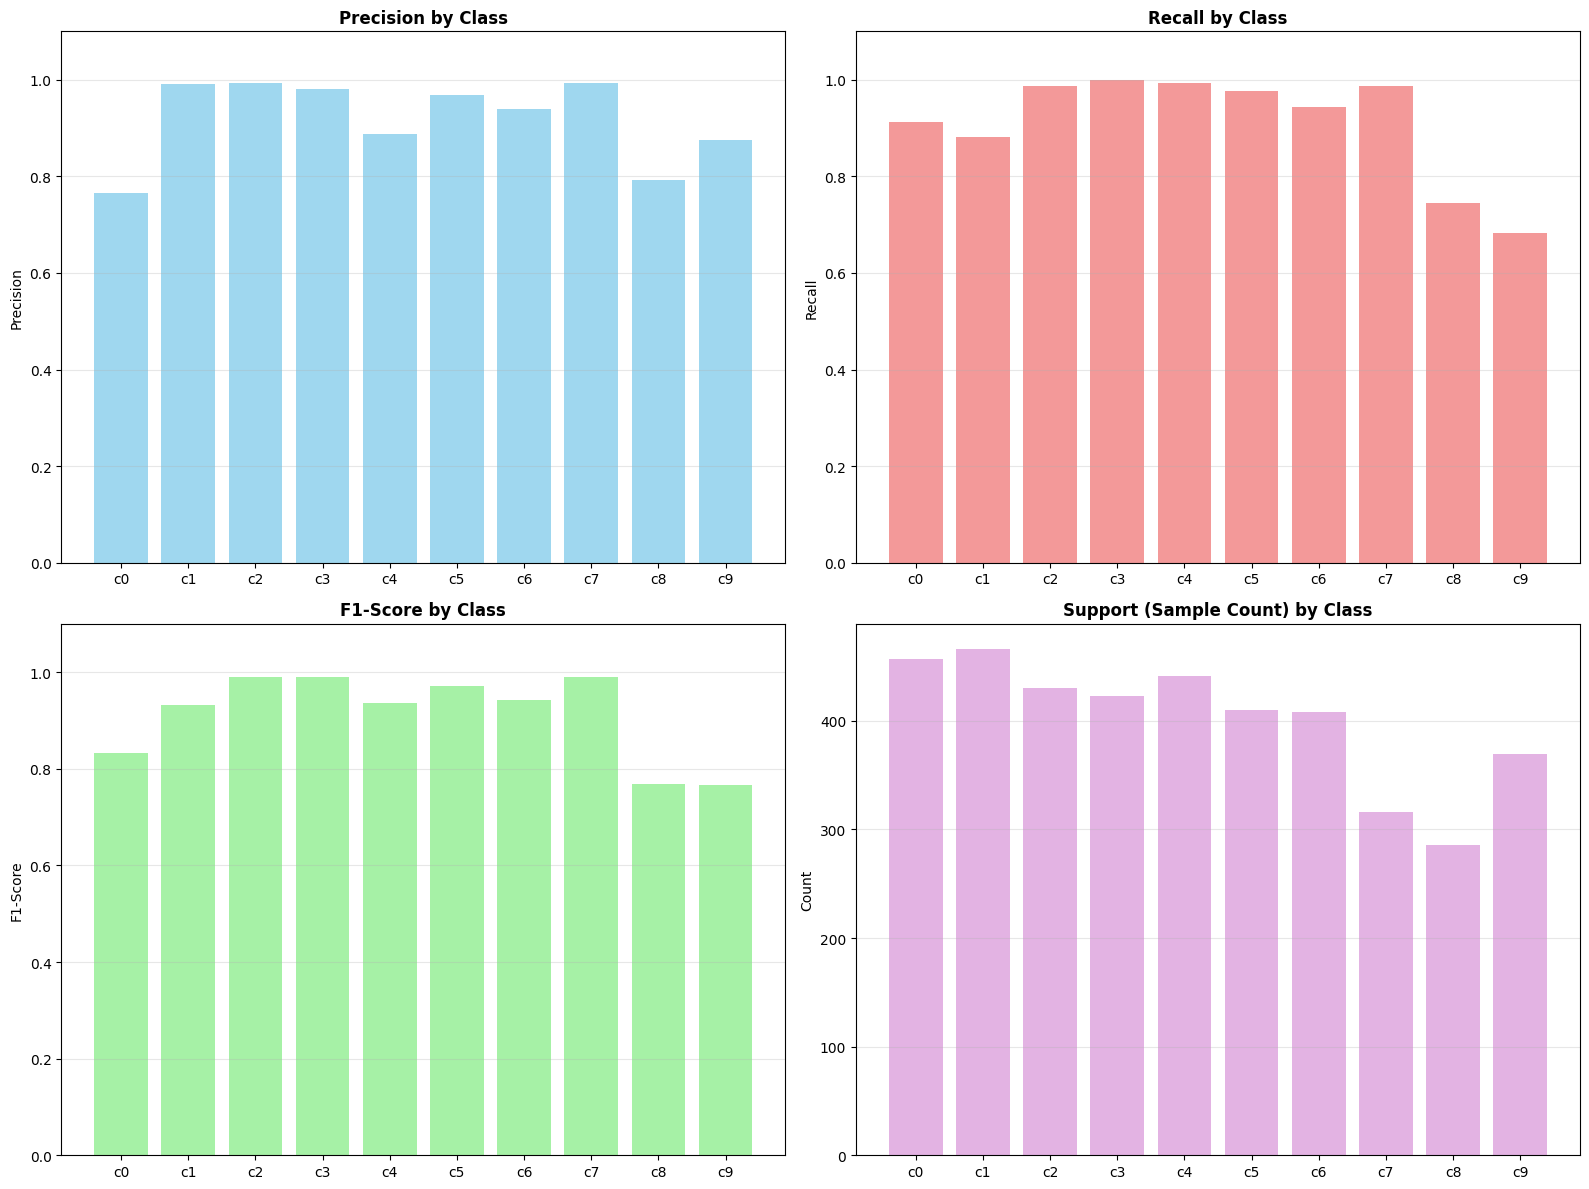

In [ ]:
# 클래스별 성능 분석
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

if 'y_true' not in globals() or 'y_pred' not in globals() or 'y_probs' not in globals():
    print("y_true/y_pred/y_probs가 없음 — analyze_predictions 실행 중...")
    y_true, y_pred, y_probs = analyze_predictions(model, val_loader, device)
else:
    print("y_true/y_pred/y_probs 이미 존재, 재계산 생략")

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

# 데이터프레임으로 정리
class_performance = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Accuracy': [accuracy_score(y_true[y_true==i], y_pred[y_true==i]) 
                 if np.sum(y_true==i) > 0 else 0 for i in range(10)]
})

print("\n" + "="*70)
print("📈 클래스별 성능")
print("="*70)
print(class_performance.to_string(index=False))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision
axes[0, 0].bar(class_names, precision, color='skyblue', alpha=0.8)
axes[0, 0].set_title('Precision by Class', fontweight='bold')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].grid(axis='y', alpha=0.3)

# Recall
axes[0, 1].bar(class_names, recall, color='lightcoral', alpha=0.8)
axes[0, 1].set_title('Recall by Class', fontweight='bold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_ylim([0, 1.1])
axes[0, 1].grid(axis='y', alpha=0.3)

# F1-Score
axes[1, 0].bar(class_names, f1, color='lightgreen', alpha=0.8)
axes[1, 0].set_title('F1-Score by Class', fontweight='bold')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Support
axes[1, 1].bar(class_names, support, color='plum', alpha=0.8)
axes[1, 1].set_title('Support (Sample Count) by Class', fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
os.makedirs(f'plots/resnet_v{version}', exist_ok=True)
plt.savefig(f'plots/resnet_v{version}/class_performance.png', dpi=300)
plt.show()

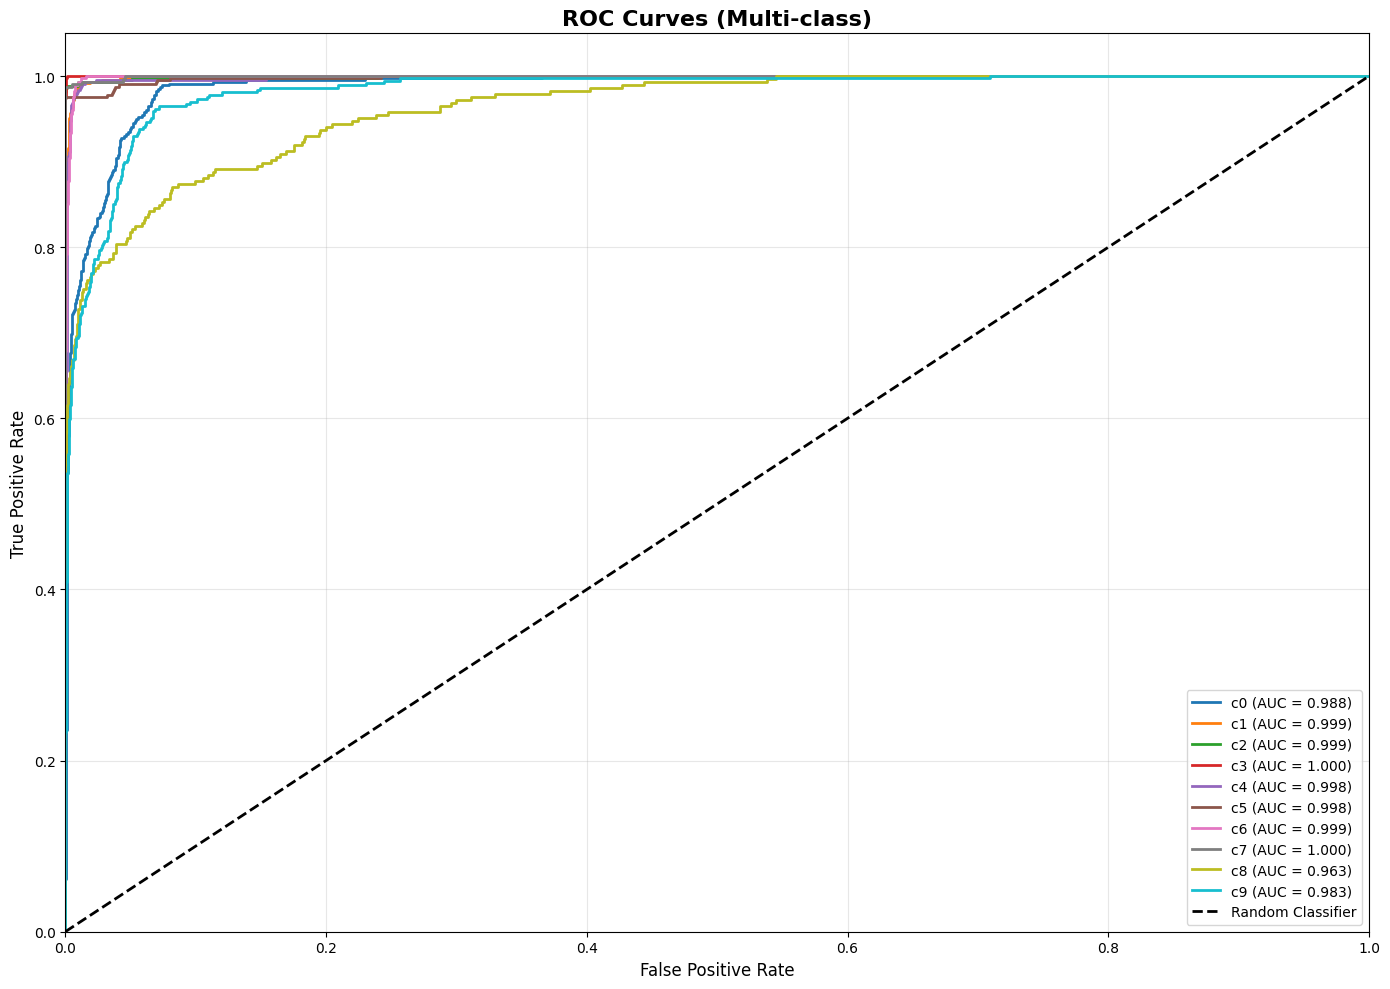

In [ ]:
# ROC Curve 분석
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot encoding
y_true_bin = label_binarize(y_true, classes=range(10))

# 각 클래스별 ROC Curve
plt.figure(figsize=(14, 10))

for i in range(10):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves (Multi-class)', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'plots/resnet_v{version}/roc_curves.png', dpi=300)
plt.show()


🔥 Grad-CAM 시각화

✅ 정답 예측 샘플


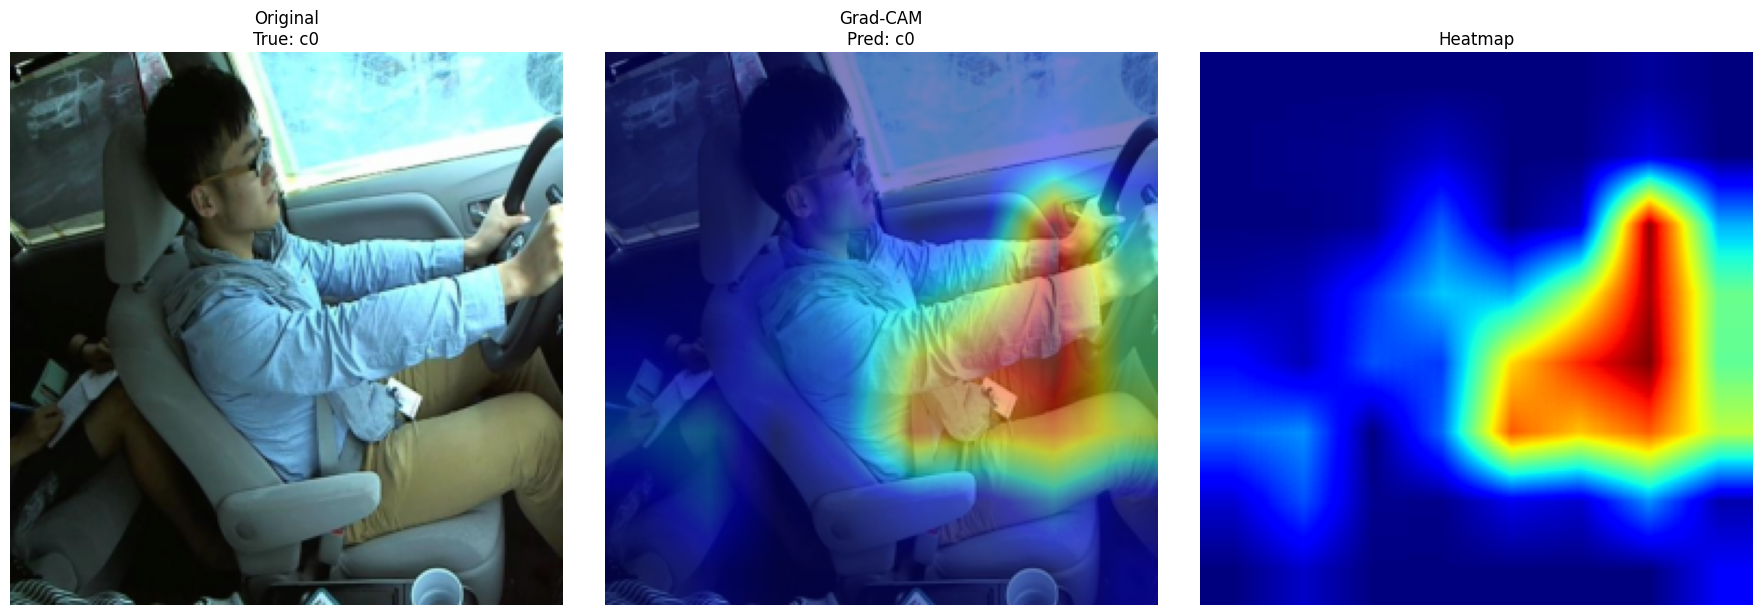

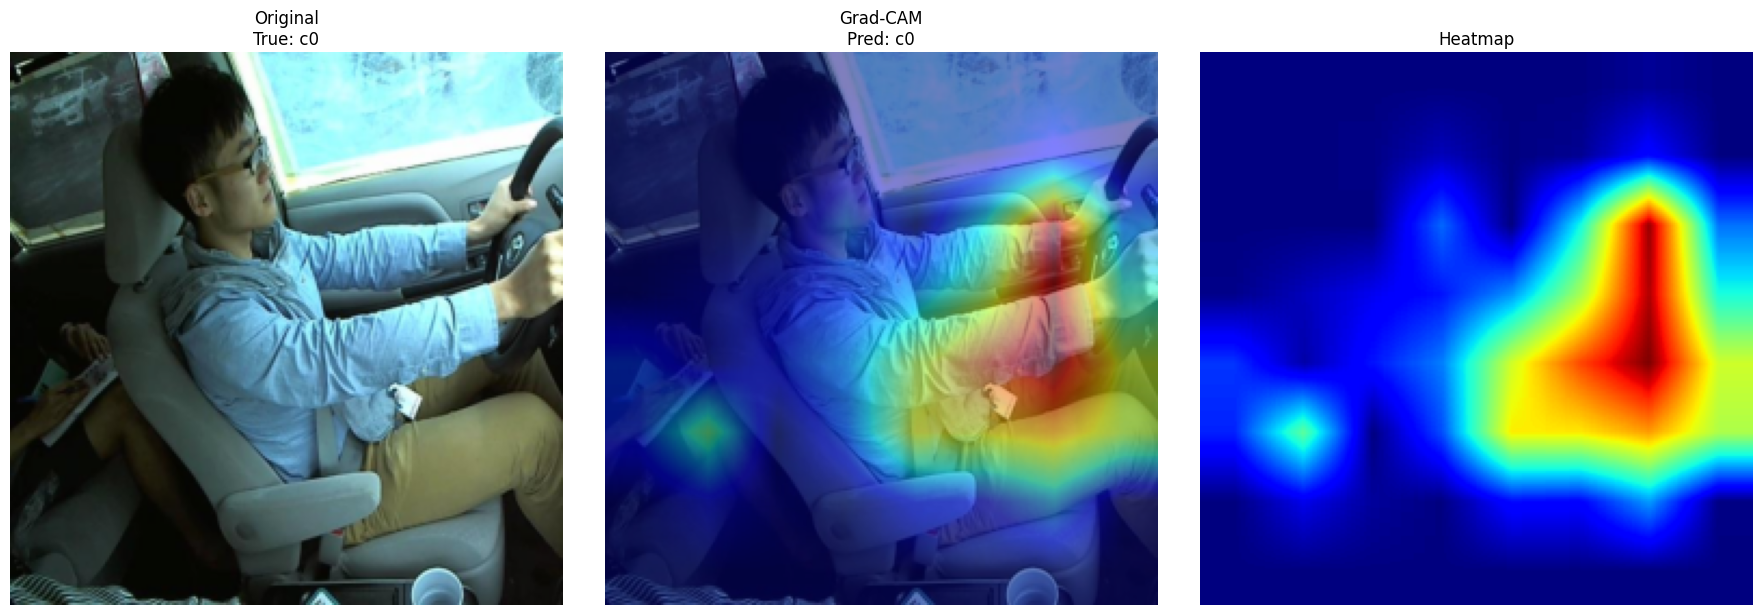

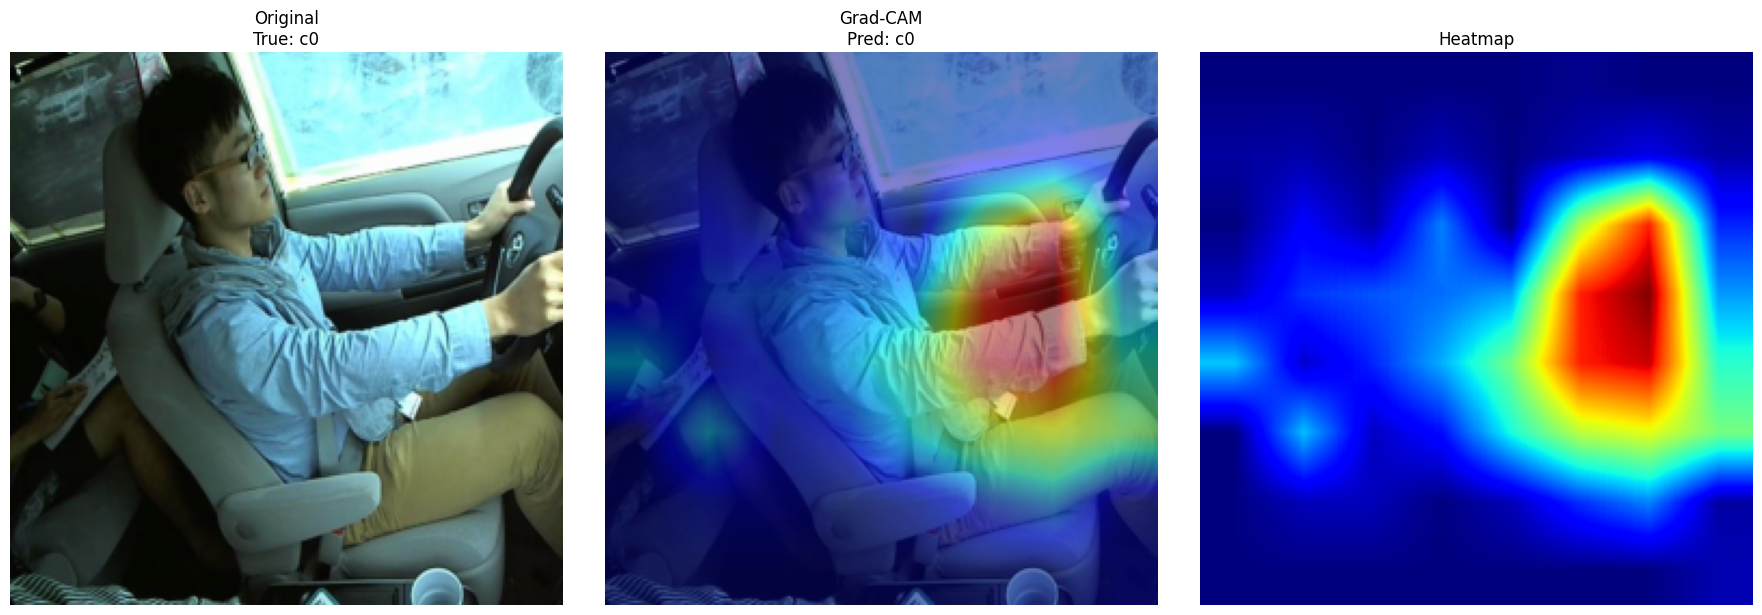


❌ 오답 예측 샘플


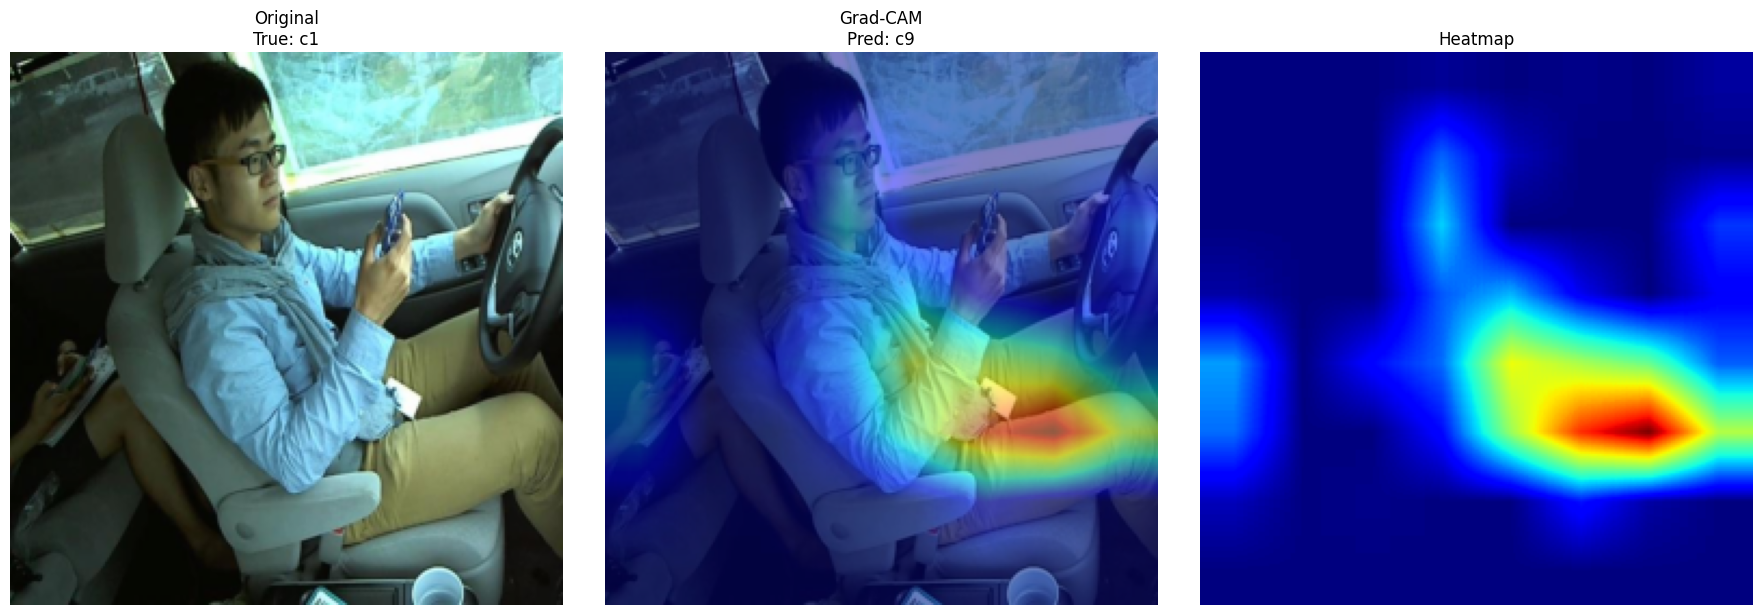

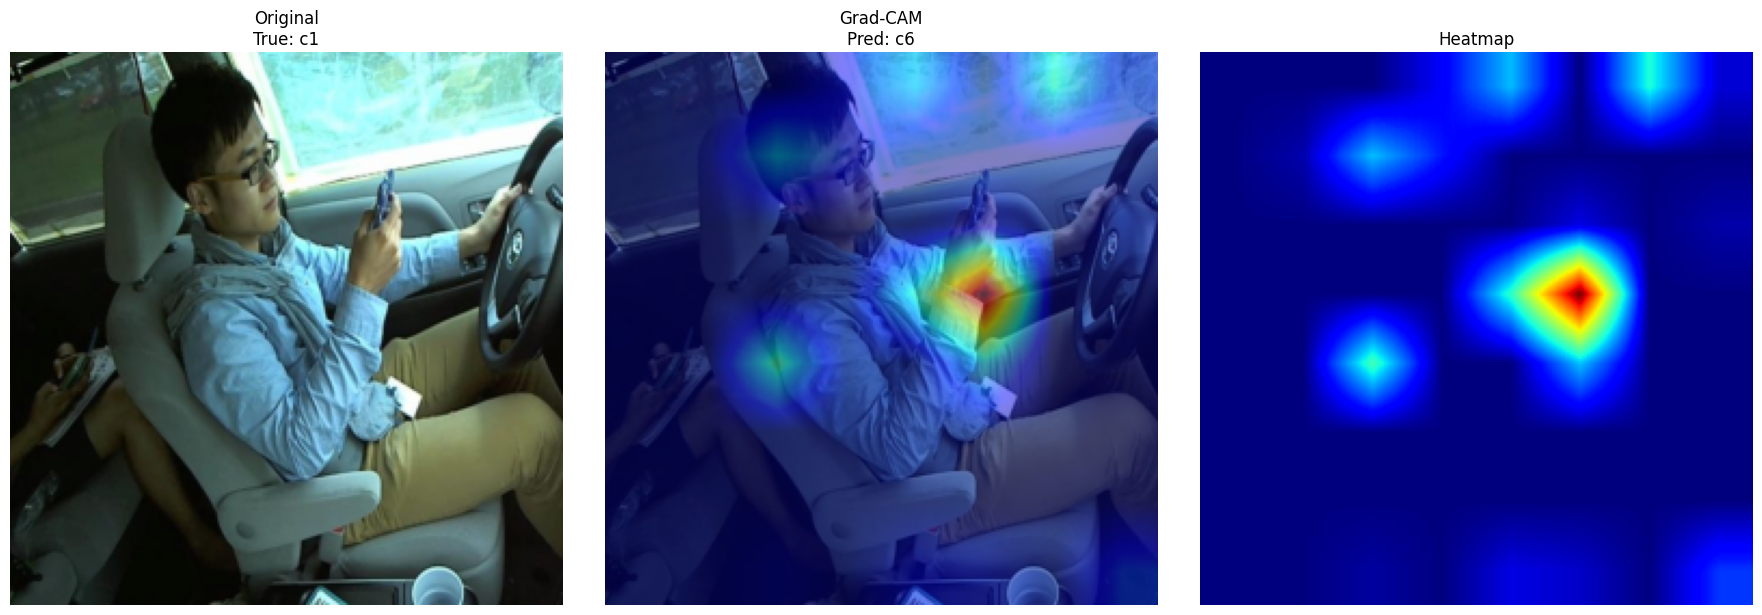

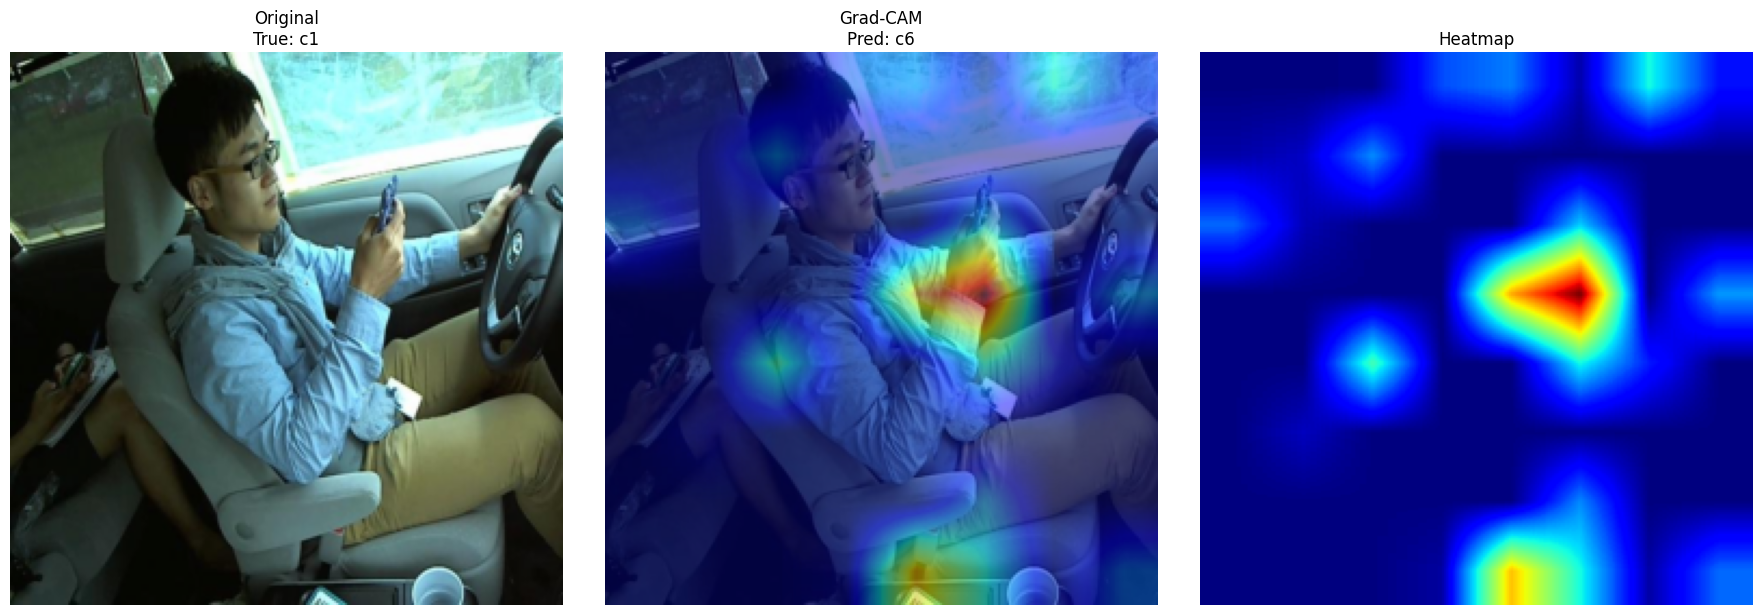

In [38]:
# Grad-CAM 구현
import torch.nn.functional as F
from torchvision.transforms import ToPILImage

class GradCAM:
    """Grad-CAM (ResNet 호환)"""
    def __init__(self, model, target_module=None):
        self.model = model
        self.target_module = target_module
        self.gradients = None
        self.activations = None

        # target_module이 None이면 모델에서 마지막 Conv2d를 찾아 사용
        if self.target_module is None:
            self.target_module, _ = get_last_conv_layer_resnet(self.model)
            if self.target_module is None:
                raise RuntimeError("마지막 Conv 레이어를 찾을 수 없습니다.")

        # 훅 등록 (forward / backward)
        self.target_module.register_forward_hook(self._save_activation)
        # 최신 PyTorch에서는 register_full_backward_hook 권장, 없으면 register_backward_hook 사용
        if hasattr(self.target_module, "register_full_backward_hook"):
            self.target_module.register_full_backward_hook(self._save_gradient)
        else:
            # 구버전 호환
            self.target_module.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        # grad_output는 tuple
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class=None):
        """
        input_tensor: [1, C, H, W] (이미 정규화된 텐서)`
        target_class: int or None (None이면 argmax 사용)
        returns: cam (H, W) float numpy [0..1], logits tensor
        """
        self.model.eval()
        self.gradients = None
        self.activations = None
            # ✅ 수정: ArcFace 사용 시 labels 없이 추론
        if hasattr(self.model, 'use_arcface') and self.model.use_arcface:
            # ArcFace 모델은 추론 시 코사인 유사도만 사용
            x = self.model.forward_features_map(input_tensor)
            x = self.model.embed(x)
            x = self.model.pool(x).flatten(1)
            x = self.model.proj(x)
            embeddings = nn.functional.normalize(x)
            W = nn.functional.normalize(self.model.classifier.weight)
            logits = nn.functional.linear(embeddings, W) * self.model.classifier.s
        else:
            logits = self.model(input_tensor)  # 일반 forward

        if target_class is None:
            target_class = int(logits.argmax(dim=1)[0])

        # backward on the score of target_class
        self.model.zero_grad()
        score = logits[0, target_class]
        score.backward(retain_graph=True)

        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients or activations not recorded. Check hooks.")

        # gradients: [1, C, H, W] -> use [C, H, W]
        gradients = self.gradients[0].cpu()
        activations = self.activations[0].cpu()

        # global average pooling of gradients -> weights [C]
        weights = gradients.mean(dim=(1, 2))  # [C]

        # weighted sum of activations
        cam = (weights[:, None, None] * activations).sum(dim=0)  # [H, W]
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        cam_np = cam.numpy().astype(np.float32)

        return cam_np, logits

def get_last_conv_layer_resnet(model):
    """
    ResNet 계열 모델에서 마지막 nn.Conv2d 모듈을 찾아 반환
    반환: (module, name) 또는 (None, None)
    """
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, torch.nn.Conv2d):
            return module, name
    return None, None

def visualize_gradcam(model, image, true_label, pred_label, device):
    """Grad-CAM 시각화 (ResNet)"""
    # target layer 찾기/설정
    target_module, target_name = get_last_conv_layer_resnet(model)
    if target_module is None:
        print("⚠️ 마지막 Conv 레이어를 찾을 수 없습니다.")
        return

    gradcam = GradCAM(model, target_module)

    # 이미지는 [C, H, W] (정규화된 텐서)
    input_tensor = image.unsqueeze(0).to(device)
    cam, output = gradcam.generate_cam(input_tensor, target_class=pred_label)

    # 원본 이미지 복원 (정규화 역변환)
    img_np = image.cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    # cam은 [H, W], float [0..1] -> uint8로 변환 후 PIL 리사이즈
    H, W = img_np.shape[:2]
    cam_uint8 = np.uint8(255 * cam)
    cam_pil = Image.fromarray(cam_uint8).resize((W, H), Image.BILINEAR)
    cam_resized = np.array(cam_pil) / 255.0

    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Original\nTrue: c{true_label}', fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(img_np)
    axes[1].imshow(cam_resized, cmap='jet', alpha=0.5)
    axes[1].set_title(f'Grad-CAM\nPred: c{pred_label}', fontsize=12)
    axes[1].axis('off')

    axes[2].imshow(cam_resized, cmap='jet')
    axes[2].set_title('Heatmap', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    return fig

# 샘플 이미지에 Grad-CAM 적용
print("\n" + "="*70)
print("🔥 Grad-CAM 시각화")
print("="*70)

# 모델 로드 (ResNetDWithHead 래퍼 사용)
model = ResNetDWithHead(
    num_classes=num_classes,
    use_gem=USE_GEM,
    embed_dim=EMBED_DIM,
    dropout=DROPOUT,
    use_arcface=USE_ARCFACE
).to(device)

checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# 검증 데이터에서 샘플 추출 (정답/오답 각각)
correct_samples = []
incorrect_samples = []

for i, (images, labels) in enumerate(val_loader):
    if len(correct_samples) >= 3 and len(incorrect_samples) >= 3:
        break
    
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images, labels)
        _, preds = torch.max(outputs, 1)
    
    for j in range(len(images)):
        if preds[j] == labels[j] and len(correct_samples) < 3:
            correct_samples.append((images[j], labels[j].item(), preds[j].item()))
        elif preds[j] != labels[j] and len(incorrect_samples) < 3:
            incorrect_samples.append((images[j], labels[j].item(), preds[j].item()))

# 정답 샘플 시각화
print("\n✅ 정답 예측 샘플")
for idx, (img, true_label, pred_label) in enumerate(correct_samples):
    fig = visualize_gradcam(model, img, true_label, pred_label, device)
    plt.savefig(f'plots/resnet_v{version}/gradcam_correct_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 오답 샘플 시각화
print("\n❌ 오답 예측 샘플")
for idx, (img, true_label, pred_label) in enumerate(incorrect_samples):
    fig = visualize_gradcam(model, img, true_label, pred_label, device)
    plt.savefig(f'plots/resnet_v{version}/gradcam_incorrect_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Feature Map 추출 및 시각화
class FeatureExtractor:
    """중간 레이어의 Feature Map 추출"""
    
    def __init__(self, model, layer_names):
        self.model = model
        self.layer_names = layer_names
        self.features = {}
        
        # Hook 등록
        for name, layer in model.named_modules():
            if name in layer_names:
                layer.register_forward_hook(self.save_feature(name))
    
    def save_feature(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook
    
    def extract(self, x):
        self.features = {}
        _ = self.model(x)
        return self.features

def visualize_feature_maps(features, layer_name, max_channels=16):
    """Feature Map 시각화"""
    feature = features[layer_name][0]  # 첫 번째 배치
    num_channels = min(feature.shape[0], max_channels)
    
    # Grid 크기 계산
    grid_size = int(np.ceil(np.sqrt(num_channels)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(num_channels):
        fmap = feature[i].cpu().numpy()
        axes[i].imshow(fmap, cmap='viridis')
        axes[i].set_title(f'Ch {i}', fontsize=8)
        axes[i].axis('off')
    
    # 빈 subplot 숨기기
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Feature Maps: {layer_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# Inception V4의 주요 레이어 이름 확인
print("\n" + "="*70)
print("🔍 모델 구조 탐색")
print("="*70)

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(f"Conv Layer: {name}")

# 주요 레이어 선택 (예시)
target_layers = [
    'backbone.conv1.6',  # 첫 번째 Conv
    'backbone.layer1.0.conv3',  # 중간 블록
    'backbone.layer2.0.conv3',  # 후반 블록
    'backbone.layer3.0.conv3',
    'backbone.layer4.0.conv3',
    'backbone.layer4.1.conv3'

]

# 샘플 이미지로 Feature Map 추출
sample_image, sample_label = next(iter(val_loader))
sample_image = sample_image[0:1].to(device)  # 첫 번째 이미지

extractor = FeatureExtractor(model, target_layers)
features = extractor.extract(sample_image)

# 각 레이어 시각화
for layer_name in target_layers:
    if layer_name in features:
        fig = visualize_feature_maps(features, layer_name, max_channels=16)
        plt.savefig(f'plots/resnet_v{version}/feature_map_{layer_name.replace(".", "_")}.png', dpi=300)
        plt.show()


🔍 모델 구조 탐색
Conv Layer: backbone.conv1.0
Conv Layer: backbone.conv1.3
Conv Layer: backbone.conv1.6
Conv Layer: backbone.layer1.0.conv1
Conv Layer: backbone.layer1.0.conv2
Conv Layer: backbone.layer1.1.conv1
Conv Layer: backbone.layer1.1.conv2
Conv Layer: backbone.layer1.2.conv1
Conv Layer: backbone.layer1.2.conv2
Conv Layer: backbone.layer2.0.conv1
Conv Layer: backbone.layer2.0.conv2
Conv Layer: backbone.layer2.0.downsample.1
Conv Layer: backbone.layer2.1.conv1
Conv Layer: backbone.layer2.1.conv2
Conv Layer: backbone.layer2.2.conv1
Conv Layer: backbone.layer2.2.conv2
Conv Layer: backbone.layer2.3.conv1
Conv Layer: backbone.layer2.3.conv2
Conv Layer: backbone.layer3.0.conv1
Conv Layer: backbone.layer3.0.conv2
Conv Layer: backbone.layer3.0.downsample.1
Conv Layer: backbone.layer3.1.conv1
Conv Layer: backbone.layer3.1.conv2
Conv Layer: backbone.layer3.2.conv1
Conv Layer: backbone.layer3.2.conv2
Conv Layer: backbone.layer3.3.conv1
Conv Layer: backbone.layer3.3.conv2
Conv Layer: backbone.la

AttributeError: 'NoneType' object has no attribute 'view'

In [ ]:
# t-SNE/UMAP으로 임베딩 시각화
from sklearn.manifold import TSNE
# pip install umap-learn
# from umap import UMAP

def extract_embeddings(model, dataloader, device):
    """마지막 FC 레이어 이전의 임베딩 추출"""
    model.eval()
    embeddings = []
    labels = []
    
    # FC 레이어 이전 출력 추출을 위한 Hook
    features = []
    def hook(module, input, output):
        features.append(input[0].detach())
    
    # Inception V4의 마지막 FC 레이어에 Hook
    if hasattr(model, 'last_linear'):
        handle = model.last_linear.register_forward_hook(hook)
    elif hasattr(model, 'fc'):
        handle = model.fc.register_forward_hook(hook)
    
    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc='임베딩 추출'):
            images = images.to(device)
            _ = model(images)
            
            embeddings.append(features[-1].cpu().numpy())
            labels.extend(lbls.numpy())
            features.clear()
    
    handle.remove()
    
    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    
    return embeddings, labels

# 임베딩 추출
print("\n" + "="*70)
print("🧬 임베딩 추출 중...")
print("="*70)

embeddings, labels = extract_embeddings(model, val_loader, device)
print(f"임베딩 shape: {embeddings.shape}")

# t-SNE 시각화
print("\n📊 t-SNE 계산 중...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=labels, 
    cmap='tab10', 
    s=10, 
    alpha=0.6
)
plt.colorbar(scatter, label='Class', ticks=range(10))
plt.title('t-SNE Visualization of Learned Embeddings', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'plots/inception_v{version}/tsne_embeddings.png', dpi=300)
plt.show()

# 클래스별로 색상 구분하여 Legend 추가
plt.figure(figsize=(16, 12))
for class_idx in range(10):
    mask = labels == class_idx
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        label=f'c{class_idx}',
        s=20,
        alpha=0.7
    )
plt.title('t-SNE Visualization by Class', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'plots/resnet_v{version}/tsne_embeddings_by_class.png', dpi=300)
plt.show()


🧬 임베딩 추출 중...


임베딩 추출:   0%|          | 0/63 [00:00<?, ?it/s]


IndexError: list index out of range